This notebook replicates how the data is generated in the Powergraph paper https://arxiv.org/abs/2402.02827

In [1]:
import numpy as np
import pandas as pd
import os
import string
import scipy.io as spio
import pandapower as pp
from pandapower.plotting.plotly import simple_plotly
from pandapower.plotting.plotly import vlevel_plotly
import pathlib
from importlib import resources

cwd = pathlib.Path.cwd()
import plotly.express as px

np.set_printoptions(linewidth=100)
from GridDataGen.utils.io import *
from GridDataGen.utils.process_network import *
from GridDataGen.utils.config import *

# Notations
- OPF: Optimal Power Flow 
- PF: Power Flow 


# Load data

In [2]:
grid_name = "case24_ieee_rts"
demand_file_grid = "IEEE24"
net = load_net_from_pp(grid_name)
demand_file = resources.files(f"GridDataGen.grids.{demand_file_grid}").joinpath(
    "hourlyDemandBusnew.mat"
)

In [3]:
# Clean-Up things in Data-Frame // give numbered item names
network_preprocessing(net)

# Overview of different pandapower dataframes:

## Load

- `net.load` contains all loads in the grid. 
    -  each bus can have 0 or max 1 load.
    - `p_mw` is the active power demand
    - `q_mvar` is the reactive power demand
    - the column `bus` indicates the bus the loads are connected to

In [ ]:
net.load

## Gen

Same as above, but:
- `p_mw` is the active power generated 
- there is no reactive power info before we run OPF or PF
- `min_p_mw`, `max_p_mw`, `min_q_mvar`, `max_q_mvar` are bounds on the active (reactive) power generated 
- `vm_pu` is the voltage in per unit


In [ ]:
net.gen

## Static generators

- sgen is static generators:

"used to model generators with a constant active and reactive power feed-in. If you want to model a voltage controlled generator, use the generator element instead."

- no voltage control

<p style="color:red"> The documentation says "If you want to model the generation of power, you have to assign a negative active power to the generator." -> this is wrong!!!!</p>

In [ ]:
net.sgen

## REF/ Slack

the slack is modelled as an external grid

In [ ]:
net.ext_grid

## Shunts

- "used to control or manage voltage levels at specific buses in a power grid. It can absorb or inject reactive power (VARs) to help maintain voltage stability."
- Think of them as controllable loads

In [ ]:
net.shunt

## lines

In [ ]:
net.line

## Transformers 

In [ ]:
net.trafo

## poly cost

$c(Pg) = cp0 + cp_1 * p_{mw} + cp_2 * p_{mw}^2 + cq_1 * q_{mvar} + cq_2 * q_{mvar}^2$

In [ ]:
net.poly_cost

## Bus types

- PV Bus: connected to gen, sgen, and sometimes also loads 
- PQ Bus: connected to loads (or nothing). Can **not** be connected to generation elements 
- Slack/ REF Bus: connected to ext_grid. Can also be connected to loads and gens 


Note that there are PQ buses which dont have any load (nor generator element, by definition)

In [ ]:
(net.bus["type"] == PQ).sum()  # number of PQ buses

In [ ]:
net.load[net.load.type == PQ].bus.nunique()  # number of PQ buses with loads

## Viz

I keep this here but I am not sure it is useful...

In [ ]:
pp.plotting.simple_plot(net)

# Assigning demand profile

In [16]:
scenarios = load_scenario_from_file(net, demand_file)

it seems the demand fluctuations over time is the same accross all buses... -> the load variations are not independent accross buses ;)

In [ ]:
px.line(scenarios[:5, :].T, title="demand timeseries for the 5 first buses")

We set the active load to what is specified in the load profile. Note that the reactive power is not changed (as in powergraph)

In [18]:
# # set demand at each load element
net.load.p_mw = scenarios[:, 0][net.load.bus]

# OPF

## Run OPF 

Now we run opf:

In [ ]:
pp.runopp(net, numba=True)

# add bus index and type to dataframe of opf results
net.res_gen["bus"] = net.gen.bus
net.res_gen["type"] = net.gen.type
net.res_load["bus"] = net.load.bus
net.res_load["type"] = net.load.type
net.res_sgen["bus"] = net.sgen.bus
net.res_sgen["type"] = net.sgen.type
net.res_shunt["bus"] = net.shunt.bus
net.res_ext_grid["bus"] = net.ext_grid.bus
net.res_bus["type"] = net.bus["type"]

after running opf, the res_* dataframes are added to the net object:

In [ ]:
net

The load of course stays the same as before

In [21]:
assert (net.load.p_mw == net.res_load.p_mw).all()
assert (net.load.q_mvar == net.res_load.q_mvar).all()

## Res gen

- res_gen now contains the optimal active and reactive power generation, as well as the voltage mag and angle

In [ ]:
net.res_gen

we can check if the constraints on the active and reactive power are respected:

In [ ]:
print("upper and lower active power margin")

print(net.gen.max_p_mw - net.res_gen.p_mw)
print(net.res_gen.p_mw - net.gen.min_p_mw)

In [ ]:
print("upper and lower reactive power margin")
print(net.gen.max_q_mvar - net.res_gen.q_mvar)
print(net.res_gen.q_mvar - net.gen.min_q_mvar)

## Res sgen

- res_sgen now contains the optimal active and reactive power generation

## Checking bounds on active and reactive power

In [25]:
if len(net.sgen) != 0:
    assert (
        net.sgen.max_p_mw - net.res_sgen.p_mw > -1e-4
    ).all(), "upper bound on active power is violated"
    assert (
        net.res_sgen.p_mw - net.sgen.min_p_mw > -1e-4
    ).all(), "lower bound on active power is violated"

    assert (
        net.sgen.max_q_mvar - net.res_sgen.q_mvar > -1e-4
    ).all(), "upper bound on reactive power is violated"
    assert (
        net.res_sgen.q_mvar - net.sgen.min_q_mvar > -1e-4
    ).all(), "lower bound on reactive power is violated"

## Slack

- slack = ext_grid now has active and reactive power: (positive means supplying power)

In [ ]:
net.res_ext_grid

## Checking power balance

- We sum the active and reactive power of all generator elements (gen, static gen and slack) connected to each bus:

In [ ]:
all_gens = (
    pd.concat([net.res_gen, net.res_sgen, net.res_ext_grid])[["p_mw", "q_mvar", "bus"]]
    .groupby("bus")
    .sum()
)
all_gens

total generation:

In [ ]:
all_gens.sum()

Load + line losses + transformer losses + shunt:

In [ ]:
all_consumption_p_mw = (
    net.res_load.p_mw.sum()
    + net.res_line.pl_mw.sum()
    + net.res_trafo.pl_mw.sum()
    + net.res_shunt.p_mw.sum()
)  # active
all_consumption_p_mw

In [ ]:
all_concumption_q_mvar = (
    net.res_load.q_mvar.sum()
    + net.res_line.ql_mvar.sum()
    + net.res_trafo.ql_mvar.sum()
    + net.res_shunt.q_mvar.sum()
)  # reactive
all_concumption_q_mvar

The total load and generation match!

## res bus

https://pandapower.readthedocs.io/en/v2.1.0/elements/bus.html#result-parameters

res bus contains the net power demand:

In [31]:
all_loads = (
    pd.concat([net.res_load, net.res_shunt])[["p_mw", "q_mvar", "bus"]]
    .groupby("bus")
    .sum()
)  # all load
net_consumption = (
    pd.concat([all_loads, -all_gens])
    .groupby("bus")
    .sum()
    .reindex_like(net.res_bus[["p_mw", "q_mvar"]])
    .fillna(0)
)  # net load = load - generation

In [32]:
assert np.allclose(net.res_bus[["p_mw", "q_mvar"]], net_consumption)

## Creating "optimal power flow targets" (targets that we should aim at predicting with GNNs)

- We store:
    - active power generated at every bus connected to generation elements (PV or slack buses)
    - reactive power generated at every bus connected to generation elements (PV or slack buses)
    - voltage mag at every bus
    - voltage angle at every bus

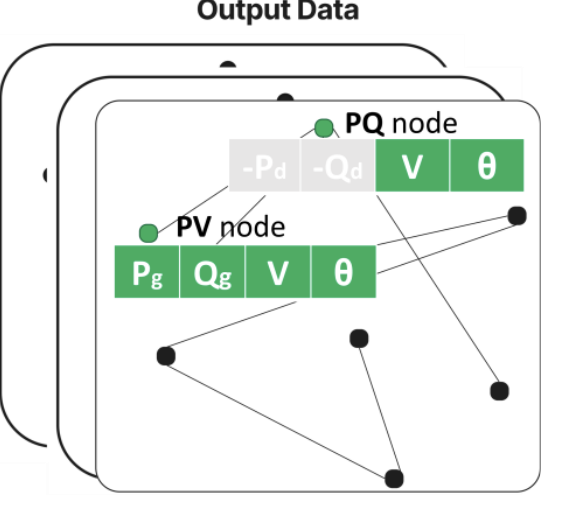

In [33]:
Y = np.zeros((net.bus.shape[0], 4))

Y[net.bus.type == PQ, 0] = 0  # no generation at PQ buses....
Y[net.bus.type == PQ, 1] = 0  # no generation at PQ buses....
Y[net.bus.type == PQ, 2] = net.res_bus.vm_pu[
    net.res_bus.type == PQ
]  # voltage magnitude
Y[net.bus.type == PQ, 3] = net.res_bus.va_degree[
    net.res_bus.type == PQ
]  # voltage angle

Y[net.bus.type == PV, 0] = all_gens.p_mw[
    net.res_bus.type == PV
]  # active Power generated
Y[net.bus.type == PV, 1] = all_gens.q_mvar[
    net.res_bus.type == PV
]  # reactive Power generated
Y[net.bus.type == PV, 2] = net.res_bus.vm_pu[
    net.res_bus.type == PV
]  # voltage magnitude
Y[net.bus.type == PV, 3] = net.res_bus.va_degree[
    net.res_bus.type == PV
]  # voltage angle


Y[net.bus.type == REF, 0] = all_gens.p_mw[
    net.res_bus.type == REF
]  # active Power generated
Y[net.bus.type == REF, 1] = all_gens.q_mvar[
    net.res_bus.type == REF
]  # reactive Power generated
Y[net.bus.type == REF, 2] = net.res_bus.vm_pu[
    net.res_bus.type == REF
]  # voltage magnitude
Y[net.bus.type == REF, 3] = net.res_bus.va_degree[
    net.res_bus.type == REF
]  # voltage angle

In [ ]:
Y

# PF

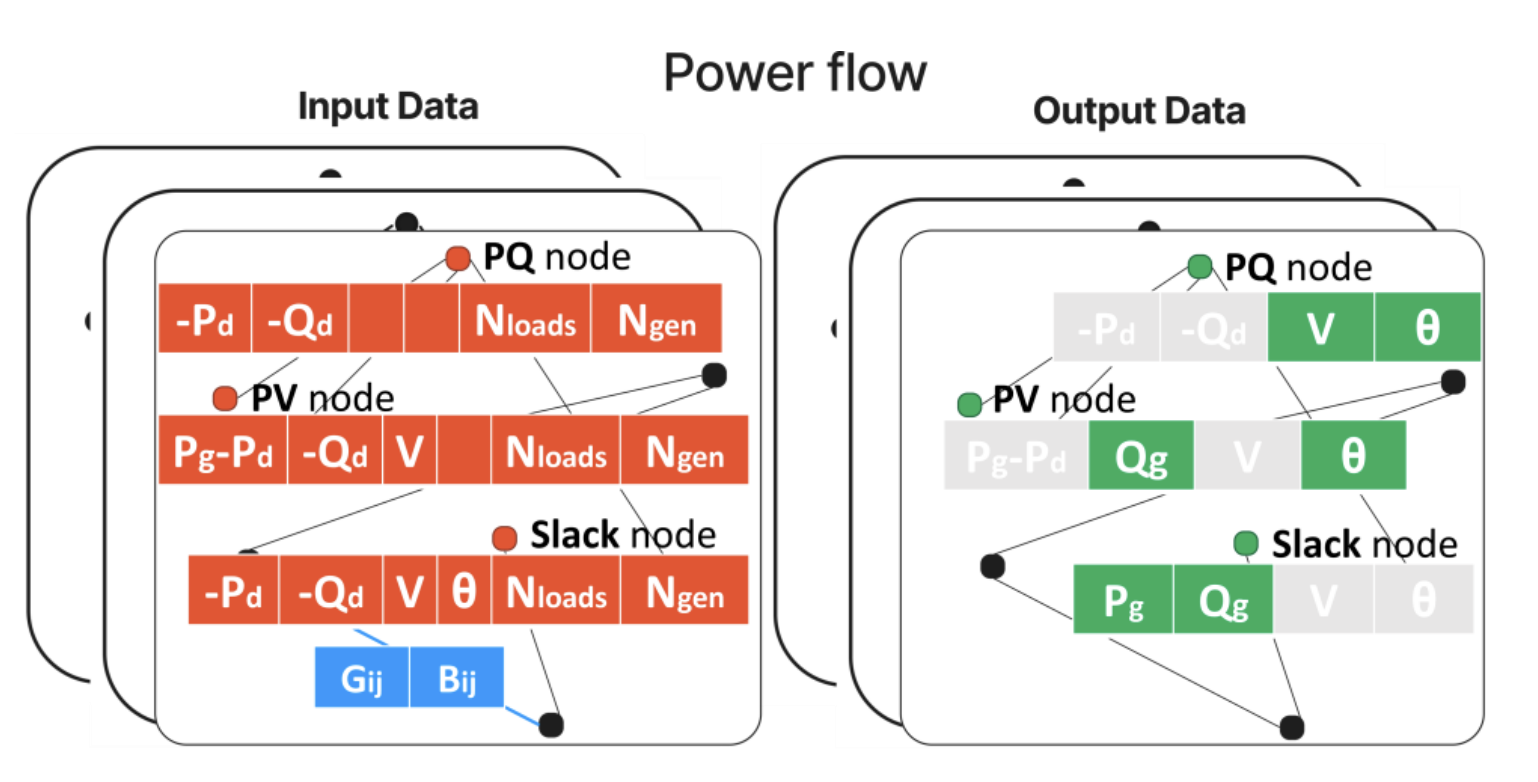

## Setting the generator power and shunt based on results of OPF


- no need to set the reactive power of generators as this is "re-computed" during PF
- We only set the real power `p_mw` and voltage `vm_pu`

In [35]:
net.gen[["p_mw", "vm_pu"]] = net.res_gen[["p_mw", "vm_pu"]]

In [36]:
net.sgen["p_mw"] = net.res_sgen["p_mw"] # note that there is no voltage info at sgens

The following is not necessary because the shunt and slack=ext_grid active and reactive power are re-computed during PF:


In [37]:
# net.shunt[["q_mvar", "p_mw"]] = net.res_shunt[
#     ["q_mvar", "p_mw"]
# ] 

In [38]:
# net.ext_grid[["q_mvar", "p_mw"]] = net.res_ext_grid[
#     ["q_mvar", "p_mw"]
# ] 

## Creating "power flow input data" = what is given as input to the model

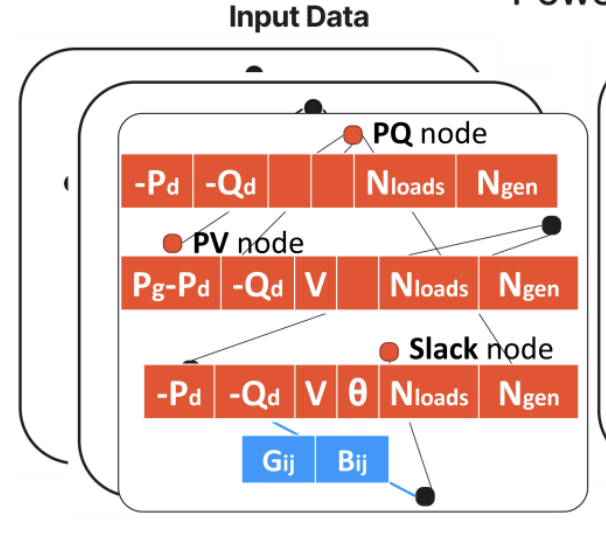

intputs:

    - net power demand at all buses except slack 
    - power demand at slack 
    - voltage magnitude at PV nodes
    

In [39]:
Xpf = np.zeros((net.bus.shape[0], 4))

REF_res_bus = net.res_bus[net.res_bus.type == REF]
PQ_res_buses = net.res_bus[net.res_bus.type == PQ]
PV_res_buses = net.res_bus[net.res_bus.type == PV]

Xpf[PQ_res_buses.index, 0] = -PQ_res_buses.p_mw
Xpf[PQ_res_buses.index, 1] = (
    -PQ_res_buses.q_mvar
) 
Xpf[PQ_res_buses.index, 2] = 0
Xpf[PQ_res_buses.index, 3] = PQ

Xpf[PV_res_buses.index, 0] = -PV_res_buses.p_mw
Xpf[net.res_load[net.res_load.type == PV].bus, 1] = -net.res_load[
    net.res_load.type == PV
].q_mvar  
Xpf[PV_res_buses.index, 2] = PV_res_buses.vm_pu
Xpf[PV_res_buses.index, 3] = PV

Xpf[REF_res_bus.index, 0] = 0 # this is an error from anna's code... the correct thing to do would have been to assign the active power demand (in case there are load elements)
Xpf[REF_res_bus.index, 1] = 0 # same comment as above
Xpf[REF_res_bus.index, 2] = REF_res_bus.vm_pu
Xpf[REF_res_bus.index, 3] = REF

In [ ]:
pp.runpp(net)

# add bus number to df of opf results
net.res_gen["bus"] = net.gen.bus
net.res_gen["type"] = net.gen.type

net.res_sgen["bus"] = net.sgen.bus
net.res_sgen["type"] = net.sgen.type

net.res_shunt["bus"] = net.shunt.bus
net.res_ext_grid["bus"] = net.ext_grid.bus
net.res_bus["type"] = net.bus["type"]

## Creating targets

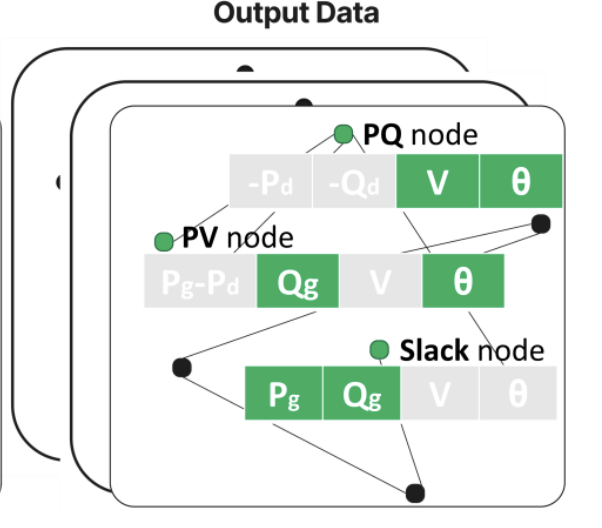

In [ ]:
all_gens_PV = (
    pd.concat(
        [net.res_gen[net.res_gen.type == PV], net.res_sgen[net.res_sgen.type == PV]]
    )[["p_mw", "q_mvar", "bus"]]
    .groupby("bus")
    .sum()
)
all_gens_PV

In [42]:
Ypf = np.zeros((net.bus.shape[0], 4))

Ypf[net.bus.type == PQ, 0] = 0  # no generation at PQ buses....
Ypf[net.bus.type == PQ, 1] = 0  # no generation at PQ buses....
Ypf[net.bus.type == PQ, 2] = net.res_bus.vm_pu[
    net.res_bus.type == PQ
]  # voltage magnitude
Ypf[net.bus.type == PQ, 3] = net.res_bus.va_degree[
    net.res_bus.type == PQ
]  # voltage angle

Ypf[net.bus.type == PV, 0] = 0
Ypf[all_gens_PV.index, 1] = (
    all_gens_PV.q_mvar
)  # reactive Power **generated** 
Ypf[net.bus.type == PV, 2] = 0
Ypf[net.bus.type == PV, 3] = net.res_bus.va_degree[
    net.res_bus.type == PV
]  # voltage angle


Ypf[net.res_ext_grid.bus, 0] = net.res_ext_grid.p_mw  # active Power generated
Ypf[net.res_ext_grid.bus, 1] = net.res_ext_grid.q_mvar  # reactive Power generated
Ypf[net.res_ext_grid.bus, 2] = 0
Ypf[net.res_ext_grid.bus, 3] = 0